# Unemployment in SA: Exploring the relationship between multiple variables that may influence the unemployment rate of South Africa

The purpose of this notebook is to explore variables that could potetially have a relationship with our response variables, i.e unemployment rate.
<br>
<br>
We will first start of by exploring which varibles have a relationship with the unemployment rate then after use those variables to answer the following questions:
<br>
<br>
**Questions:**<br>
Is there a significant relationship between the variables identifed and the unemployment rate?
<br>
<br>
We will explore this relationship using the regression slope test that has a regression line of the format:
<br>
$$
Y=\beta_{i} X \ for \ i = 0,1,2...m
$$
Where $X$ are the selected variables and $\beta_{i}$ are the respective coefficients.Thus, the **hypothesis** is as follows:
$$
\begin{array}{l}{\mathrm{H}_{\mathrm{0}} : \beta_{0}=\beta_{1}=...=\beta_{m}=0} \\ {\mathrm{H}_{\mathrm{1}} : \beta_{i} \neq 0 } \ for \ at \ least\ one \ i\end{array}
$$

<br>
<br>
I will be using the $F$-test to simultaneously check the significance of a number of regression coefficients.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# South African Reserve Bank Cleaned Economic Data

Data prepared for modelling from the South African Reserve Bank

This data can used for both regression and classification research questions i.e. forecast the unemployment rate.

The original data was sourced from https://www.resbank.co.za/en/home/what-we-do/statistics/releases/economic-and-financial-data-for-south-africa


## The full feature set
*These feature were accessed from the South African Reserve Bank.*

*There are **147 features in total**, these cover a significant portfion of the South African economy*

**The data from 1922-01-01 to 2020-01-01** if it used for unemployment forecasting, deleting redudant observations is helpful

In [2]:
feature_set_sarb = pd.read_csv('sarb_features_data.csv').drop(['unemployment rate'], axis=1).set_index('Date')
target = pd.read_csv('sarb_target_data.csv').set_index('Date')

# Data Preparation

## Missing Data from mixing frequencies

The missing data occurs because we are merging data that is monthly and data that is quartely, hence all quartely data should be expected to have missing data. This is normal when dealing with multiple time series.


In [3]:
#Here we visualize the frequency of missingness of each feature
feature = feature_set_sarb.isna().sum()/len(feature_set_sarb)

feature = feature.sort_values(ascending=False)
feature_df = pd.DataFrame(feature.index, columns=['Feature Name'])
feature_df['Missing Frequency'] = np.array(feature.values)
feature_df['Rank'] = feature_df['Missing Frequency'].rank(ascending=False)
#feature_df
feature_df

,Feature Name,Missing Frequency,Rank
0,Loans _y,0.986732,1.0
1,Consolidated general government: Liabilities: ...,0.959497,2.0
2,The difference between cash-flow revenue and c...,0.958799,3.0
3,Total South African population,0.958101,4.0
4,Foreign debt of S.A.: Total foreign debt,0.953212,5.0
...,...,...,...
142,Total gross loan debt (nsa),0.497207,132.0
143,The net borrowing requirement of national gove...,0.497207,132.0
144,Total outstanding domestic marketable bills,0.497207,132.0
145,Foreign exchange rate : SA rand per USA dollar,0.496508,146.0


<BarContainer object of 147 artists>

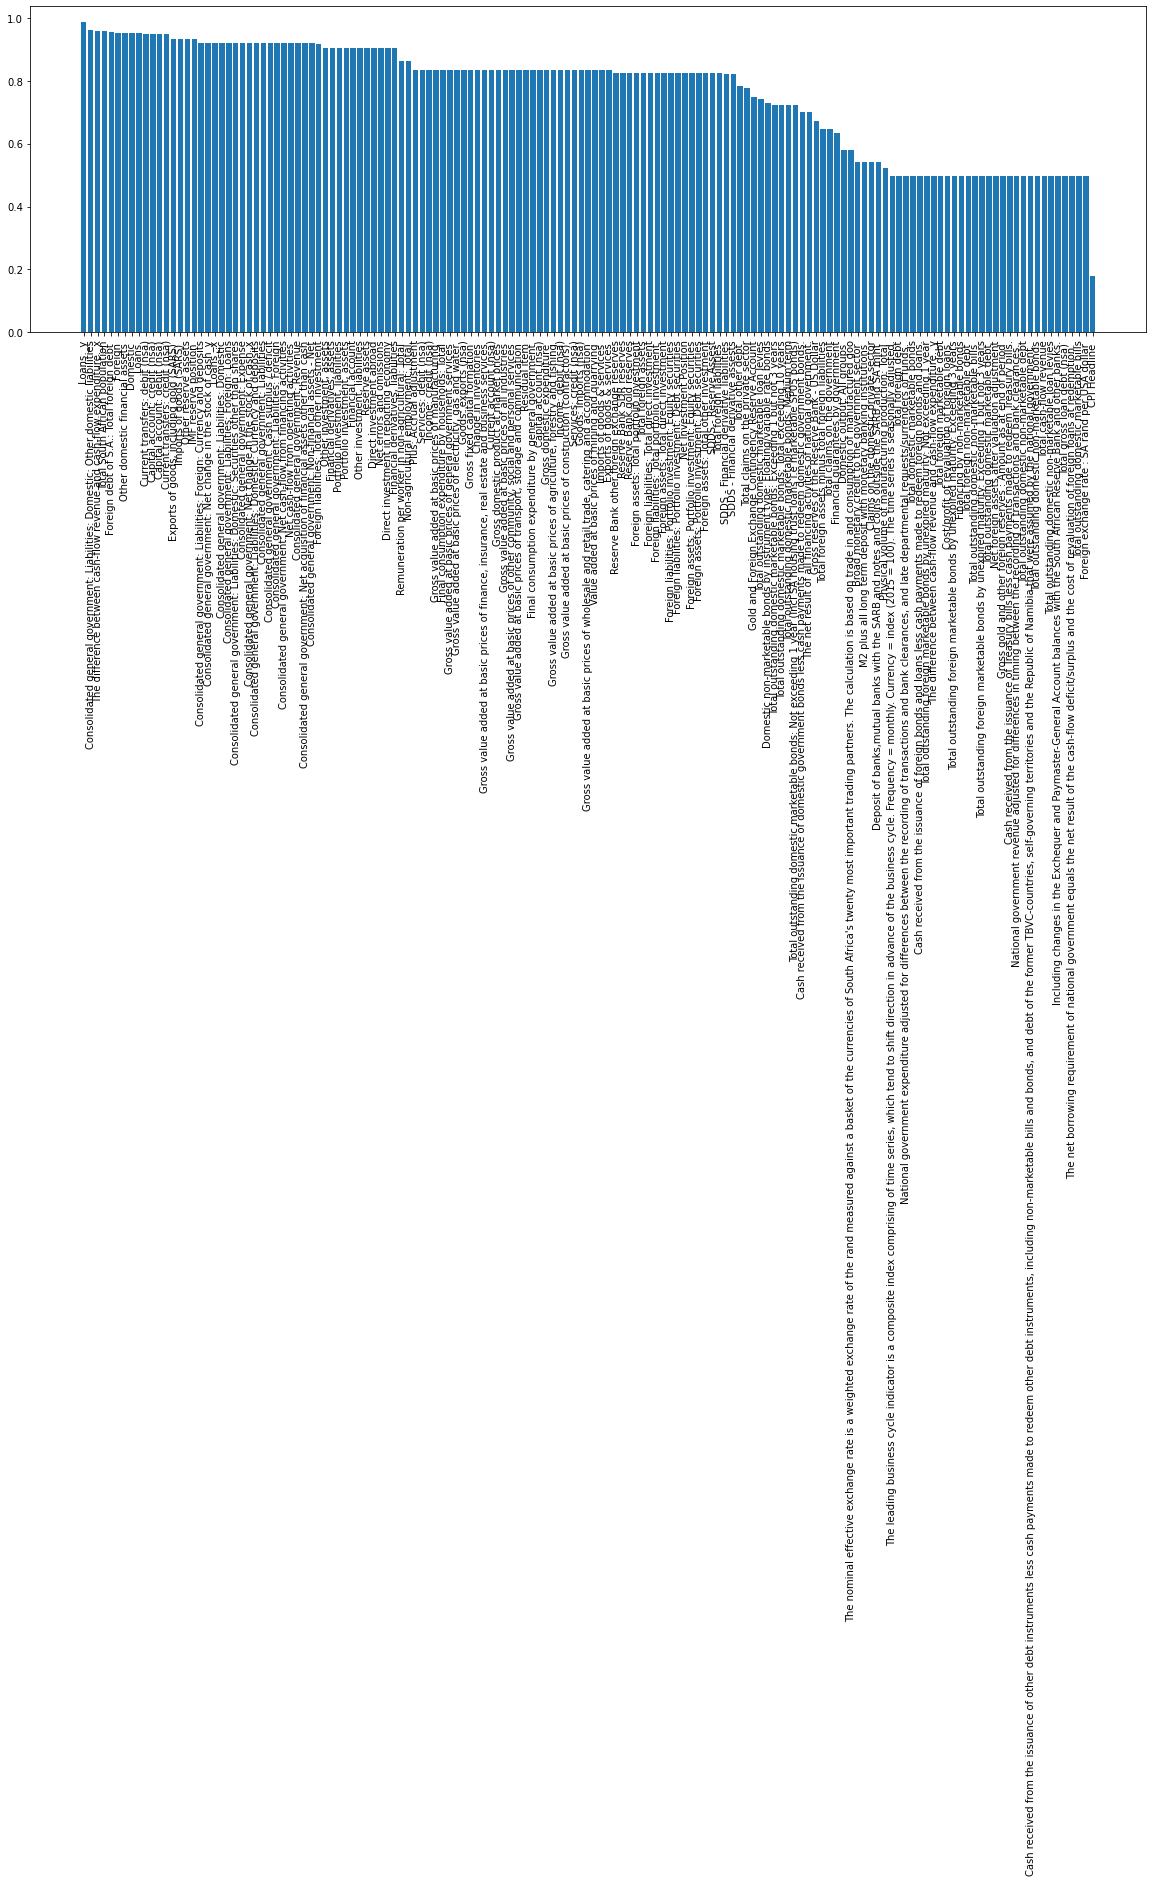

In [4]:
plt.figure(figsize=(20,6))
plt.xticks(rotation=90)
plt.bar(feature_df['Feature Name'], feature_df['Missing Frequency'])

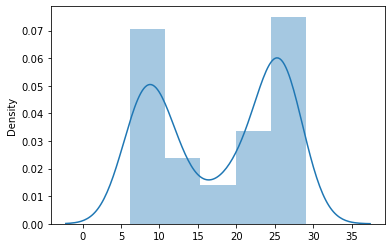

In [5]:
# The distribution of the target variable before cleaning
ax = sns.distplot(target)

In [6]:
feature_count = feature_set_sarb.count()/len(feature_set_sarb)

feature_count = feature_count.sort_values(ascending=False)
feature_count_df = pd.DataFrame(feature_count.index, columns=['Feature Name'])
feature_count_df['Frequency'] = np.array(feature_count.values)
feature_count_df['Rank'] = feature_count_df['Frequency'].rank(ascending=False)
#feature_df
feature_count_df

,Feature Name,Frequency,Rank
0,CPI Headline,0.821229,1.0
1,Foreign exchange rate : SA rand per USA dollar,0.503492,2.0
2,Total outstanding domestic non-marketable debt,0.502793,16.0
3,The net borrowing requirement of national gove...,0.502793,16.0
4,Total outstanding domestic non-marketable loan...,0.502793,16.0
...,...,...,...
142,Foreign debt of S.A.: Total foreign debt,0.046788,143.0
143,Total South African population,0.041899,144.0
144,The difference between cash-flow revenue and c...,0.041201,145.0
145,Consolidated general government: Liabilities: ...,0.040503,146.0


<BarContainer object of 147 artists>

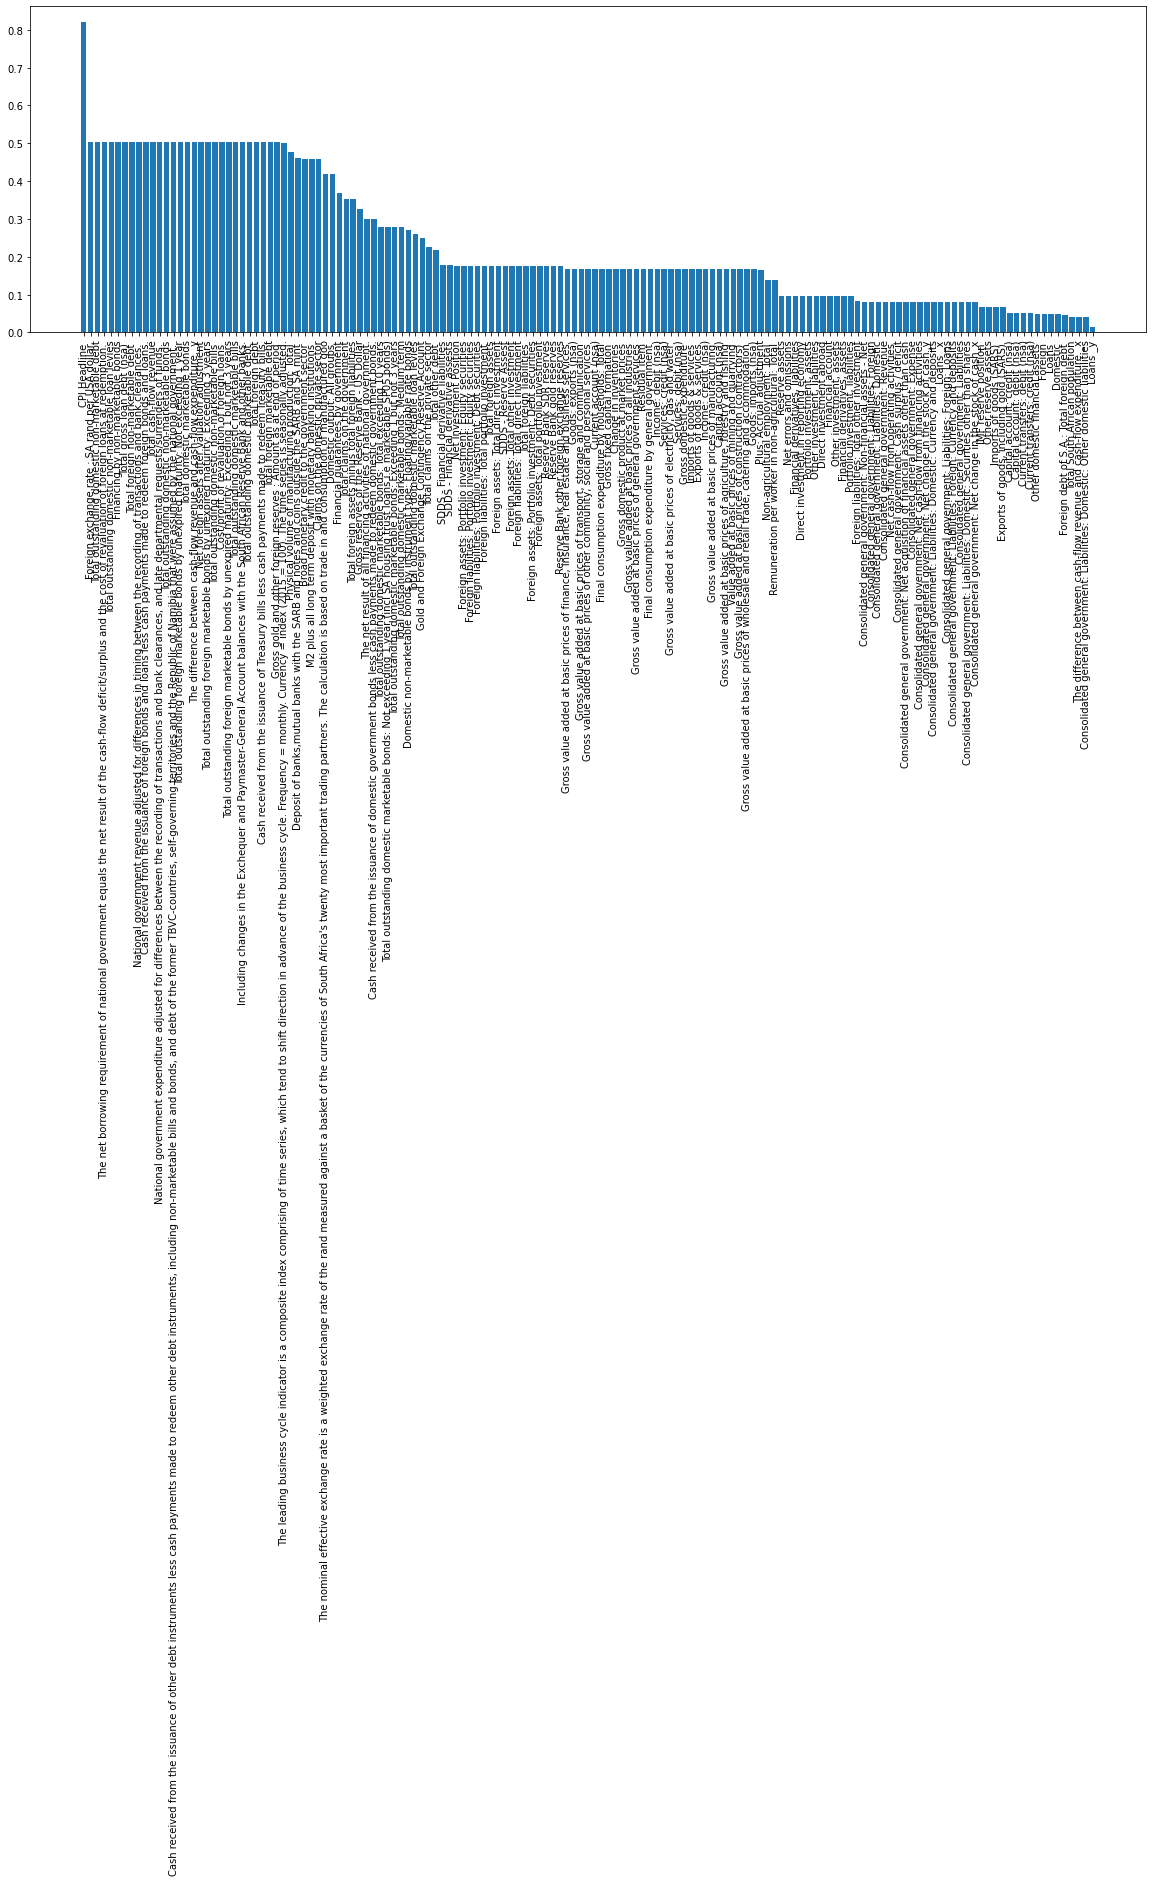

In [7]:
plt.figure(figsize=(20,6))
plt.xticks(rotation=90)
plt.bar(feature_count_df['Feature Name'], feature_count_df['Frequency'])

In [8]:
# Data imputation strategy is foward fill i.e last know value imputation
# Economic data usually does not change that much from month to month.
x_values_ffill = feature_set_sarb.fillna(method='ffill')
y_values_ffill = target.fillna(method='ffill')

In [9]:
# Remove all data points before unemployment rate data is available. Unemployment rate is my target variable.
valid_start = y_values_ffill.first_valid_index()
y_values_ffill = y_values_ffill[valid_start : ]
x_values_ffill = x_values_ffill[valid_start : ]

In [10]:
#We fill with NA here to avoid any features that might be NA i.e. insurance
x_values_ffill = x_values_ffill.fillna(0)
x_values_ffill.isna().sum()

Final consumption expenditure by general government             0
Consolidated general government: Revenue                        0
Foreign liabilities: Total portfolio investment                 0
Foreign liabilities: Portfolio investment: Equity securities    0
Domestic output: All groups                                     0
                                                               ..
Gross domestic expenditure                                      0
Net cash-flow from operating activities                         0
Non-agricultural employment: Total                              0
Consolidated general government: Expense                        0
Residual item                                                   0
Length: 147, dtype: int64

In [11]:
# data distribution after data wrangling
feature_count = x_values_ffill.count()

feature_count = feature_count.sort_values(ascending=False)
feature_count_df = pd.DataFrame(feature_count.index, columns=['Feature Name'])
feature_count_df['Frequency'] = np.array(feature_count.values)
feature_count_df['Rank'] = feature_count_df['Frequency'].rank(ascending=False)
#feature_df
feature_count_df

,Feature Name,Frequency,Rank
0,Residual item,794,74.0
1,Gross reserves of the Reserve Bank - US Dollar,794,74.0
2,Including changes in the Exchequer and Paymast...,794,74.0
3,Total outstanding domestic marketable bonds: E...,794,74.0
4,Total foreign assets,794,74.0
...,...,...,...
142,Consolidated general government: Liabilities: ...,794,74.0
143,The difference between cash-flow revenue and c...,794,74.0
144,Total domestic marketable bonds,794,74.0
145,Total outstanding foreign marketable bonds by ...,794,74.0


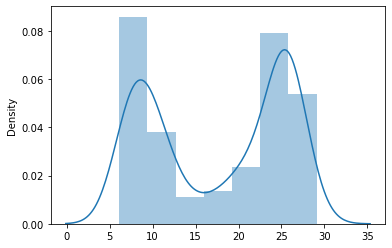

In [12]:
# The distribution of the target variable after cleaning
ax = sns.distplot(y_values_ffill)

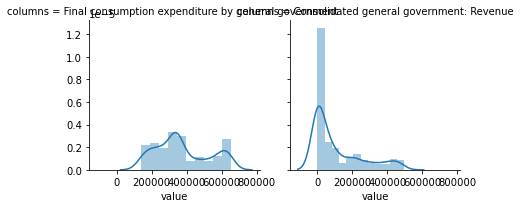

In [13]:
df = x_values_ffill.iloc[:,0:2]
dfm = df.melt(var_name='columns')
g = sns.FacetGrid(dfm, col='columns')
g = (g.map(sns.distplot, 'value'))

# Exploratory Analysis

In [47]:
predictors = x_values_ffill
target = y_values_ffill
X_desc = predictors.describe()
X_desc

,Final consumption expenditure by general government,Consolidated general government: Revenue,Foreign liabilities: Total portfolio investment,Foreign liabilities: Portfolio investment: Equity securities,Domestic output: All groups,Final consumption expenditure by households: Total,Gross fixed capital formation,SDDS - Financial derivative liabilities,Foreign liabilities: Portfolio investment: Debt securities,Change in inventories,...,Physical volume of manufacturing production: Total,Remuneration per worker in non-agricultural: Total,Consolidated general government: Non-financial assets - Net,Consolidated general government: Cash surplus / deficit,CPI Headline,Gross domestic expenditure,Net cash-flow from operating activities,Non-agricultural employment: Total,Consolidated general government: Expense,Residual item
count,794.000000,794.000000,794.000000,794.000000,794.000000,7.940000e+02,794.000000,794.000000,794.000000,794.000000,...,794.000000,794.000000,794.000000,794.000000,794.000000,7.940000e+02,794.000000,794.000000,794.000000,794.000000
mean,373665.612091,108277.746851,573.060453,395.347607,61.362720,1.092396e+06,347353.962217,32.836272,177.683879,3809.312343,...,78.417254,46.297985,-8828.735516,-5544.627204,36.188791,1.863535e+06,3284.057935,86.334761,104993.610831,46310.442065
std,151566.020052,142947.358077,1011.060785,689.793030,42.929349,4.703964e+05,156458.832642,60.028836,326.337515,25607.574674,...,17.843678,52.608128,11735.208755,15068.111840,32.987443,7.223534e+05,12833.029644,16.123574,141421.292252,66980.498676
min,142014.000000,0.000000,0.000000,0.000000,4.100000,4.575410e+05,176103.000000,0.000000,0.000000,-59774.000000,...,38.300000,0.900000,-38794.000000,-82087.000000,1.600000,9.326500e+05,-55201.000000,49.200000,0.000000,-56597.000000
25%,252700.000000,0.000000,3.000000,2.000000,17.600000,7.086292e+05,227432.000000,0.000000,1.000000,-9526.000000,...,68.000000,4.000000,-19113.000000,-6742.500000,5.825000,1.337564e+06,0.000000,76.500000,0.000000,-5324.000000
50%,345089.500000,39392.000000,22.000000,10.000000,65.400000,9.490095e+05,276222.500000,0.000000,12.000000,5424.000000,...,77.300000,22.800000,-3144.500000,0.000000,27.900000,1.561847e+06,0.000000,89.900000,40141.000000,21704.000000
75%,498951.000000,194384.000000,668.000000,549.000000,93.825000,1.550581e+06,526021.000000,21.000000,124.250000,19390.750000,...,95.575000,72.500000,0.000000,0.000000,56.700000,2.572331e+06,9840.500000,99.500000,160541.000000,108380.000000
max,653236.000000,494482.000000,3628.000000,2556.000000,163.300000,1.961051e+06,644549.000000,241.000000,1277.000000,66699.000000,...,109.900000,174.000000,0.000000,14729.000000,113.800000,3.251797e+06,35605.000000,106.900000,518165.000000,223468.000000


In [17]:
df_mean = X_desc.loc['mean']
df_max = X_desc.loc['max']

print(df_mean[X_desc.loc['mean']>X_desc.loc['50%']].count())
print(df_mean[X_desc.loc['max']>X_desc.loc['75%']].count())

120
142


From the above table you can notice that the mean value is greater than median value for 120 columns which indicate that most of the column disbribution is positively distributed.

There is notably a large difference between 75th %tile and max values of of all columns this observation tells us tha there is an existance of outliers in our dataset.


# Feature Selection

In [49]:
def calculate_vif_(X, thresh=10):
    """Calculation of VIFs to reduce multicollinearity problems.

    Parameters:
    -----------
    X : pandas DataFrame with all possible predictors and
    without the response variable

    thresh: integer, threshold by which to exclude variables
    for dataset

    Returns:
    --------
    remaining: list of variable names that still remain in 
               the dataset

    """
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

#     print('Remaining variables:')
#     print(X.columns[variables])
    remaining=cols[variables]
    return remaining

In [64]:
def remove_inflated_variables(data,sample_size,print_out=True):
    """Calculation of VIFs to reduce multicollinearity problems
    using a subset of the data

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and
    the response variable

    sample_size: integer, size of the sample used to estimate the
    VIFs
    
    print_out : whether to print the sequence of exclusions

    Returns:
    --------
    remaining: list of variable names that still remain in 
               the dataset

    """
    sample_train=resample(data,n_samples=sample_size)
    #sample_dummy_mod = sample_train.drop(['Salary','Year'], axis = 1)
    remaining=calculate_vif_(sample_train)
    return remaining

In [65]:
remaining=remove_inflated_variables(predictors,300)

dropping 'Consolidated general government: Net change in the stock of cash_x' at index: 32
dropping 'Reserve assets' at index: 46
dropping 'Gross domestic expenditure ' at index: 140
dropping 'Consolidated general government: Revenue' at index: 1
dropping 'Consolidated general government: Net cash-flow from financing activities' at index: 125
dropping 'Total outstanding domestic marketable debt ' at index: 52
dropping 'Consolidated general government: Liabilities' at index: 76
dropping 'Total gross loan debt (nsa) ' at index: 21
dropping 'Consolidated general government: Liabilities: Domestic' at index: 91
dropping 'Consolidated general government: Cash surplus / deficit' at index: 132
dropping 'Domestic ' at index: 128
dropping 'Total foreign debt' at index: 64
dropping 'National government expenditure adjusted for differences between the recording of transactions and bank clearances, and late departmental requests/surrenders of funds. ' at index: 119
dropping 'Total foreign assets' a

In [67]:
remaining

(42,)

In [68]:
remaining

Index(['Change in inventories ',
       'Foreign exchange rate : SA rand per USA dollar ',
       'Other domestic financial assets ', 'Net Investment Position',
       'Foreign ', 'Financing by non-marketable bonds',
       'Total cash-flow revenue',
       'Cash received from the issuance of other debt instruments less cash payments made to redeem other debt instruments, including non-marketable bills and bonds, and debt of the former TBVC-countries, self-governing territories and the Republic of Namibia that were assumed by the national government. ',
       'Net errors and omissions', 'SDDS - Financial derivative assests',
       'Capital account: debit (nsa)',
       'Consolidated general government: Liabilities: Foreign: Currency and deposits',
       'Total outstanding domestic marketable loan levies',
       'Cash received from the issuance of domestic government bonds less cash payments made to redeem domestic government bonds.',
       'Cash received from the issuance of forei